# Digging Beneath the Surface

*Benjamin Johnson*


*March 2, 2018*

[Home](https://fastdatascientist.github.io/Digging-Beneath-the-Surface/)

[About Me](https://fastdatascientist.github.io/Digging-Beneath-the-Surface/author.html)

[Previous Posts](https://fastdatascientist.github.io/Digging-Beneath-the-Surface/posts.html)

## Parameter Optimization for Bill Bergen Fantasy Baseball

More baseball! In 2017, three fellow baseball nerds and myself formed the Bill Bergen Memorial Fantasy Baseball League. Being bored of the traditional formats, our goal was to create a league where the goal was for the WORST possible players to accumulate the HIGHEST points. By awarding points for batter strikeouts and subtracting for positive outcomes (hits, RBIs, runs), league managers would be incentivized to select the poorest performing postion players. Likewise, a similar scoring system was established for pitchers, awarding points for giving up hits & runs, while scoring negative points for getting outs. If you're curious about the league's namesake, I highly recommend the article [here](https://blogs.fangraphs.com/the-worst-hitter-in-baseball-history/).

&nbsp;

The idea was simple in concept, but this led to some headscratching when devising the rules. How many points should be awarded for each event?

&nbsp;

While the inaugural 2017 season was established with cherry-picked parameters, the purpose of this analysis was to optimize the parameters by creating the most negative relationship between the historical performance and fantasy rankings for traditional leagues.

&nbsp;

Let's dive into things.

### Import libraries and define function

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import optimize

%matplotlib inline
matplotlib.style.use('ggplot')

def remove_whitespace(x):
    try:
        x = "".join(x.split())
    except:
        pass
    return x

### Read in fantasy projections

Our first step is to read in expert draft rankings for MLB players in 2018. The data was provided by [FantasyPros](https://www.fantasypros.com/mlb/).

In [3]:
rank = pd.read_csv(r'C:\Users\Benjamin\Digging Beneath the Surface\data\FantasyPros_Fantasy_Baseball_Rankings_ALL.csv',encoding = "ISO-8859-1")
rank['Name'] = rank['Player'].apply(remove_whitespace)
rank = rank[['Name','Rank']]
rank.head()

,Name,Rank
0,MikeTrout,1.0
1,JoseAltuve,2.0
2,NolanArenado,3.0
3,TreaTurner,4.0
4,PaulGoldschmidt,5.0


### Read in 2017 batting player stats

Baseball consist of pitchers and position players. We need to create separate scoring parameters for both types. Let's import the 2017 player statistics, available on [MLB's website](https://www.mlb.com/stats/).

&nbsp;

Below, we'll start by parsing out the 2017 batting statistics for position players.

In [4]:
xl = pd.ExcelFile(r'C:\Users\Benjamin\Digging Beneath the Surface\data\MLB 2017 Player Stats.xlsx')
batting = xl.parse("Batting")
#batting['Name'] = batting['Name'].str.strip()
batting['Name'] = batting['Name'].apply(remove_whitespace)
batting["1B"] = (batting['H'] - batting['HR'] - batting['3B'] - batting['2B'])
batting = batting[['Name','PA','BB','SO','1B','2B','3B','HR','SB','R','RBI']]
batting = batting[batting['PA'] >= 100]
batting.head()

,Name,PA,BB,SO,1B,2B,3B,HR,SB,R,RBI
0,A.J.Ellis,163,12,29,19,5,0,6,0,17,14
1,A.J.Pollock,466,35,71,60,33,6,14,20,73,49
2,AaronAltherr,412,32,104,53,24,5,19,5,58,65
3,AaronHicks,361,51,67,47,18,0,15,10,54,52
4,AaronJudge,678,127,208,75,24,3,52,9,128,114


### Read in 2017 pitching player stats

Next, we'll split out the pitcher statistics.

In [5]:
pitching = xl.parse("Pitching")
pitching['Name'] = pitching['Name'].apply(remove_whitespace)
pitching = pitching[['Name','G','W','L','IP','ER','H','BB','HR','SO','HBP','BK','WP']]
pitching = pitching[pitching['IP'] > 75]
pitching.head()


,Name,G,W,L,IP,ER,H,BB,HR,SO,HBP,BK,WP
1,A.J.Griffin,18,6,6,77.1,51,76,28,20,61,6,0,2
7,AaronNola,27,12,11,168.0,66,154,49,18,184,2,0,1
11,AdalbertoMejia,21,4,7,98.0,49,110,44,13,85,5,2,2
12,AdamConley,22,8,8,102.2,70,114,42,19,72,8,0,5
17,AdamWainwright,24,12,5,123.1,70,140,45,14,96,5,0,2


### Merge batting stats with fantasy rankings

Continuing with position players, we'll combine the historical stats with the 2018 rankings.

In [6]:
batting_merge = pd.merge(batting, rank, how='inner',on='Name')
batting_merge.head()

,Name,PA,BB,SO,1B,2B,3B,HR,SB,R,RBI,Rank
0,A.J.Pollock,466,35,71,60,33,6,14,20,73,49,53.0
1,AaronAltherr,412,32,104,53,24,5,19,5,58,65,241.0
2,AaronHicks,361,51,67,47,18,0,15,10,54,52,252.0
3,AaronJudge,678,127,208,75,24,3,52,9,128,114,20.0
4,AbrahamAlmonte,195,20,46,26,8,3,3,2,26,14,664.0


### Define optimization function

In the next step, we define the batting attributes that will be used in our fantasy scoring. We also define a function to calculate the negative correlation between a given parameter set compared against the 2018 rankings.

&nbsp;

A significant issue last year was that many players wound up with negative point values, which encouraged league managers to keep their position slots empty. To account for this, we'll create a batting constraint that requires the parameters be optimized such that at ~70%+ of the players have non-negative point values based on 2017 data.

In [94]:
batting_attr =  ['PA','BB','SO', '1B','2B','3B','HR','SB','R','RBI']
rank_array = batting_merge['Rank']

# Batting constraint to increase number of non-negative players
def bat_con(batting_values):
    values = np.zeros(len(rank_array)) 
    for i, j in enumerate(batting_attr):
        values = values + batting_merge[j] * batting_values[i]
    pct = len([1 for i in values if i > 0])/len(values)
    return pct - 0.7

bat_cons = {'type':'ineq', 'fun': bat_con}

# Batting Corrlelation Function
def bat_funct(batting_values):
    values = np.zeros(len(rank_array)) 
    for i, j in enumerate(batting_attr):
        values = values + batting_merge[j] * batting_values[i]
    batting_merge['values'] = values
    return(-1 * np.corrcoef(batting_merge['values'], batting_merge['Rank'])[1,0])

### Evaluate correlation using 2017 parameter set

Since this is our 2nd year playing in the league, we should first evaluate the correlation for the parameters used in 2017.

In [89]:
# batting_attr =  ['PA','BB','SO', '1B','2B','3B','HR','SB','R','RBI']
initial =          [2.5, -3.0, 2.0, -2.5, -5, -6, -10, -10, -6, -7]
orig = bat_funct(initial)

pct =  len(batting_merge[batting_merge['values'] > 0])/len(batting_merge['values'])

print("The correlation coefficient for the 2017 parameter set is " + str("{:,.2f}".format(orig)))
print("The percentage of players with positive scores is " + str("{:,.2f}".format(pct * 100)) + "%")

The correlation coefficient for the 2017 parameter set is -0.64
The percentage of players with positive scores is 45.19%


### Run optimization to find new parameter set

Now that last year's settings have been evaluated, let's try to optimize the settings to yield the most negative correlation between 2017 Fantasy Points scored and 2018 rankings.

In [95]:
opt_model = optimize.minimize(bat_funct, x0=initial, method='COBYLA', constraints=bat_cons) 
opt_values = opt_model.x
opt = bat_funct(opt_values)

pct =  len(batting_merge[batting_merge['values'] > 0])/len(batting_merge['values'])
    
print("The correlation coefficient for the optimized parameter set is " + str("{:,.2f}".format(opt)))
print("The percentage of players with positive scores is " + str("{:,.2f}".format(pct * 100)) + "%")
print("The parameter set is as follows: " + str(opt_values))

The correlation coefficient for the optimized parameter set is -0.57
The percentage of players with positive scores is 66.03%
The parameter set is as follows: [  2.5112766   -2.72721009   2.63895482  -2.54707378  -5.04880382
  -5.75563266  -9.93149576 -10.02224247  -5.72451385  -6.71866211]


Our correlation is slightly lower, -0.57 vs -0.64, but our percentage of players with positive points increased from 45.19% to 66.03%. This will make it much easier for league managers to fill their rosters with point-producing players.

&nbsp;

Next, we'll make some slight manual tweaks to the settings to round them and apply some conceptual logic, such as forcing Homeruns to have a higher absolute value than triples.


### Manually tweak settings (rounding + common sense, e.g. HR > 3B)

In [96]:
#batting_attr =  ['PA','BB','SO', '1B','2B','3B','HR','SB','R','RBI']
opt_values2 =    [2.5, -2.5, 2.5,  -2.5, -5,  -6,  -10, -10, -5.5, -6.5]
opt2 = bat_funct(opt_values2)

pct =  len(batting_merge[batting_merge['values'] > 0])/len(batting_merge['values'])

print("The correlation coefficient for the optimized parameter set is " + str("{:,.2f}".format(opt2)))
print("The percentage of players with positive scores is " + str("{:,.2f}".format(pct * 100)) + "%")

The correlation coefficient for the optimized parameter set is -0.56
The percentage of players with positive scores is 68.27%


Excellent! Our values are slightly cleaner and our correlation is still in tact.

## Create scatterplot

Let's take a look at how our newly calculation for 2017 fantasy points compare against the 2018 expert ratings. As can be expected from our 0.57 correlation coefficient, there is a clear trend between 2017 points and 2018 rating. However, it's highly variable and doesn't follow a neat distribution. From experience in 2017, we found that two players ranked similarly in standard leagues could have wildly different Bergen Fantasy point totals due to their number of strikeouts, which aren't nearly as detrimental in regular leagues.

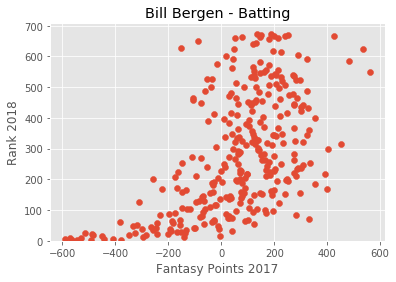

In [307]:
plt.scatter(batting_merge['values'], batting_merge['Rank'])

plt.ylim(0)
plt.title('Bill Bergen - Batting')
plt.xlabel('Fantasy Points 2017')
plt.ylabel('Rank 2018')
plt.show()


### Repeat for pitchers

Let's repeat a very similar analysis for pitchers.

In [100]:
pitching_merge = pd.merge(pitching, rank, how='inner',on='Name')
pitching_merge.head()

,Name,G,W,L,IP,ER,H,BB,HR,SO,HBP,BK,WP,Rank
0,AaronNola,27,12,11,168.0,66,154,49,18,184,2,0,1,70.0
1,AdalbertoMejia,21,4,7,98.0,49,110,44,13,85,5,2,2,636.0
2,AdamConley,22,8,8,102.2,70,114,42,19,72,8,0,5,590.0
3,AdamWainwright,24,12,5,123.1,70,140,45,14,96,5,0,2,491.0
4,AddisonReed,77,2,3,76.0,24,65,15,11,76,1,0,2,317.0


Just like with batters, we'll initiate our pitching attributes, define a constraint function, and calculation the correlation coefficient.

In [101]:
pitching_attr =  ['HR','BB','SO','WP','ER','L','BK']
rank_array = pitching_merge['Rank']

def pitch_con(pitching_values):
    values = np.zeros(len(rank_array)) 
    for i, j in enumerate(pitching_attr):
        values = values + pitching_merge[j] * pitching_values[i]
    pct = len([1 for i in values if i > 0])/len(values)
    return pct - 0.7

pitch_cons = {'type':'ineq', 'fun': pitch_con}

def pitch_funct(pitching_values):
    values = np.zeros(len(rank_array)) 
    for i, j in enumerate(pitching_attr):
        values = values + pitching_merge[j] * pitching_values[i]
    pitching_merge['values'] = values
    return(-1 * np.corrcoef(pitching_merge['values'], pitching_merge['Rank'])[1,0])

### Evaluate correlation using 2017 parameter set

In [103]:
# pitching_attr =  ['HR','BB','SO','WP','ER','L','BK']
initial =          [5,    3,   -3,  3,   3,   5,   3]
orig = pitch_funct(initial)

pct =  len(pitching_merge[pitching_merge['values'] > 0])/len(pitching_merge['values'])

print("The correlation coefficient for the 2017 parameter set is " + str("{:,.2f}".format(orig)))
print("The percentage of players with positive scores is " + str("{:,.2f}".format(pct * 100)) + "%")

The correlation coefficient for the 2017 parameter set is -0.70
The percentage of players with positive scores is 77.03%


Since pitchers have more variables which allow them to score Bergen Fantasy Points (i.e. negative outcomes in the traditional sense), the 2017 parameters lead to a much higher percentage of non-negative total points by player. We'll continue with optimizing the parameters for the 2018 season.

In [107]:
opt_model = optimize.minimize(pitch_funct, x0=initial, method='COBYLA', constraints=pitch_cons) 
opt_values = opt_model.x
opt = pitch_funct(opt_values)

print("The correlation coefficient for the optimized parameter set is " + str("{:,.2f}".format(opt)))
print("The parameter set is as follows: " + str(opt_values))

The correlation coefficient for the optimized parameter set is -0.73
The parameter set is as follows: [ 4.77857984  2.60510896 -3.13027031  3.25321508  2.94560936  5.11126572
  4.01031509]


Our 2017 parameters turned out pretty well! The optimized parameter set was nearly identical at -0.73 vs -0.70 for the baseline.

In [108]:
# pitching_attr =  ['HR','BB','SO','WP','ER','L','BK']
opt_values2 =      [ 4.5, 4,  -3, 3.5,  2.5, 4.5,  3 ]
opt2 = pitch_funct(opt_values2)

pct =  len(pitching_merge[pitching_merge['values'] > 0])/len(pitching_merge['values'])

print("The correlation coefficient for the optimized parameter set is " + str("{:,.2f}".format(opt2)))
print("The percentage of players with positive scores is " + str("{:,.2f}".format(pct * 100)) + "%")

The correlation coefficient for the optimized parameter set is -0.70
The percentage of players with positive scores is 77.70%


After applying some cleanup logic, our optimized parameter matches the baseline parameters. For simplicity, we'll likely continue using the 2017 parameter values for the 2018 season. Still, let's create a visual to compare the optimized settings against the 2017 Fantasy Point totals.

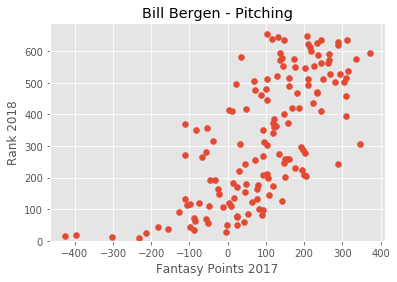

In [109]:
plt.scatter(pitching_merge['values'], pitching_merge['Rank'])

plt.ylim(0)
plt.title('Bill Bergen - Pitching')
plt.xlabel('Fantasy Points 2017')
plt.ylabel('Rank 2018')
plt.show()


There's still a lot of variation, but you can see a much clearer, somewhat linear correlation for pitchers.

### Conclusion

Added in June 2022:

&nbsp;

If you're still reading to this point, thanks for spending the time reviewing the analysis! While it was was a fun project to work on, it took me over 4 years to finalize my notes for the article. We indeed switched over to the new batting parameter values for 2018-onward and maintained the pitching values used in 2017. 

&nbsp;

Now that I'm back from my long hiatus, there's a new, non-baseball related article available that you might enjoy. Feel free to check it out, and I hope to have smaller, more frequent articles posted in the near future. Thanks again!


&nbsp;

Until next time,
&nbsp;

Ben